# I2P Traffic Analysis Notebook
Datenverkehrsanalyse basierend auf aufgezeichnetem I2P-Netzwerkverkehr. Dabei wird der gesamte Verkehr analysiert, im Hinblick auf die HTTP-Requests.

In [46]:
!pip install scapy matplotlib numpy pandas scipy


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [47]:
from scapy.all import rdpcap

source_ip = '10.8.0.2'
target_ip = '10.8.0.11'
packets = rdpcap('traffic_with_filter.pcap')

In [48]:
from scapy.all import IP, TCP, UDP
import numpy as np
from scipy.stats import entropy

is_source_filter_enabled = True
# Filter alle Pakete raus, welche nicht die target_ip als Empfänger haben
filtered_packets = [
    pkt for pkt in packets
    if IP in pkt
       and pkt[IP].dst == target_ip
       and (pkt[IP].src == source_ip if is_source_filter_enabled else True)
]

print(f"Anzahl der Pakete zu {target_ip}: {len(filtered_packets)}")

Anzahl der Pakete zu 10.8.0.11: 435


# Anzahl der Pakete vom Sender zu einem anderen Knoten.
Damit soll der erste Sprungknoten identifiziert werden.

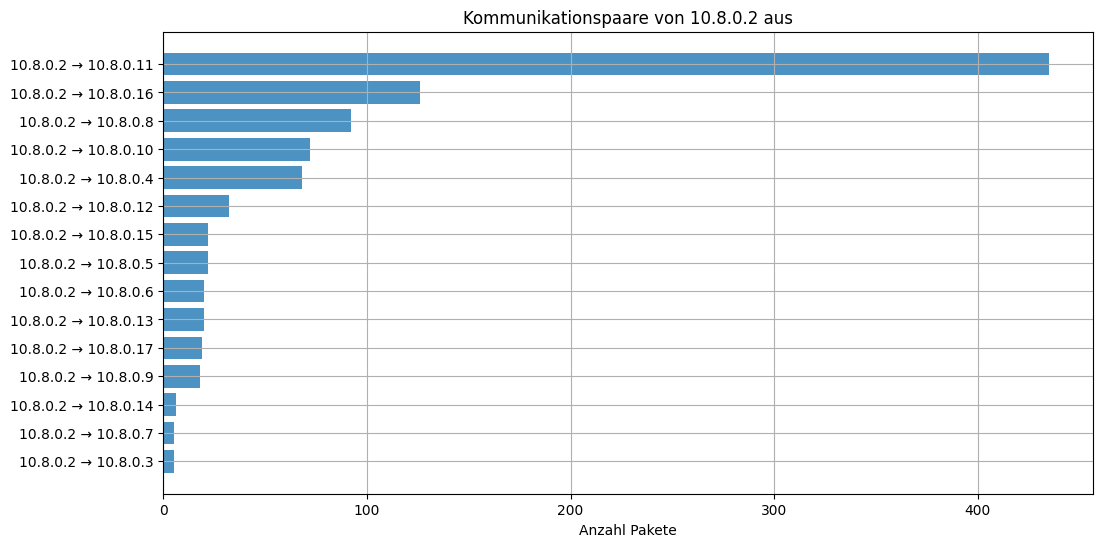

Verbindungen und Anzahl Pakete:
10.8.0.2 → 10.8.0.11: 435
10.8.0.2 → 10.8.0.16: 126
10.8.0.2 → 10.8.0.8: 92
10.8.0.2 → 10.8.0.10: 72
10.8.0.2 → 10.8.0.4: 68
10.8.0.2 → 10.8.0.12: 32
10.8.0.2 → 10.8.0.15: 22
10.8.0.2 → 10.8.0.5: 22
10.8.0.2 → 10.8.0.6: 20
10.8.0.2 → 10.8.0.13: 20
10.8.0.2 → 10.8.0.17: 19
10.8.0.2 → 10.8.0.9: 18
10.8.0.2 → 10.8.0.14: 6
10.8.0.2 → 10.8.0.7: 5
10.8.0.2 → 10.8.0.3: 5


In [49]:
from collections import Counter
from scapy.all import IP
import matplotlib.pyplot as plt

#Muss angepasst werden, wenn anderer Sender
source_ip = source_ip
is_showed = True

# Filter
flows = [
    (pkt[IP].src, pkt[IP].dst)
    for pkt in packets
    if IP in pkt and pkt[IP].src == source_ip and pkt[IP].dst.startswith("10.")
]

flow_counts = Counter(flows).most_common()
flow_labels = [f"{src} → {dst}" for src, dst in dict(flow_counts).keys()]
flow_values = list(dict(flow_counts).values())

plt.figure(figsize=(12, 6))
plt.barh(flow_labels, flow_values, alpha=0.8)
plt.xlabel('Anzahl Pakete')
plt.title(f'Kommunikationspaare von {source_ip} aus')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

if is_showed:
    print("Verbindungen und Anzahl Pakete:")
    for (src, dst), count in flow_counts:
        print(f"{src} → {dst}: {count}")


## Zählen der Kommunikation aller Knoten mit allen anderen Knoten im Netzwerk.
Es zeigt, welche Knoten häufig miteinander kommunizieren.

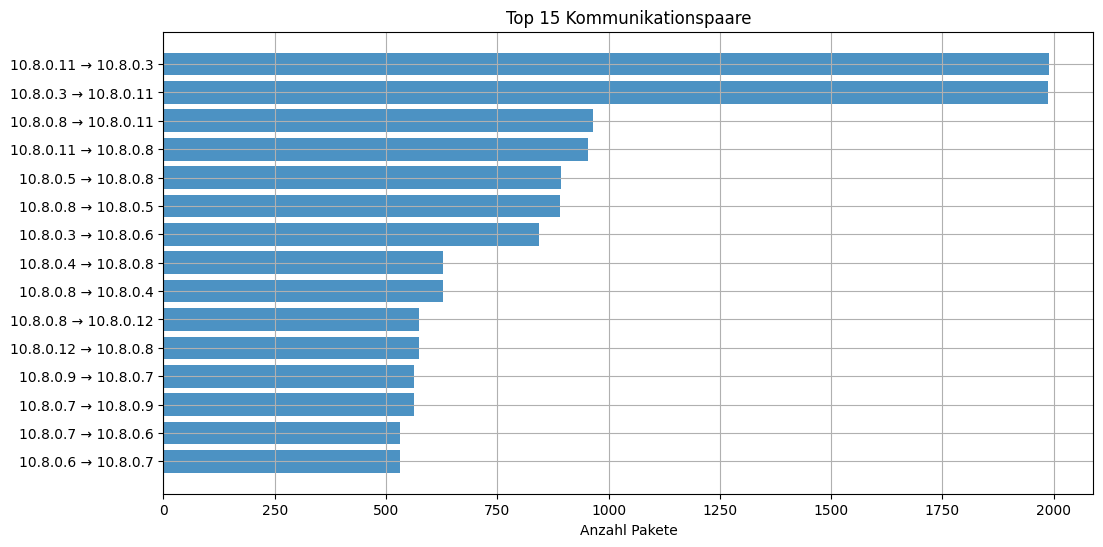

In [50]:
flows = [(pkt[IP].src, pkt[IP].dst) for pkt in packets if IP in pkt]

flow_counts = Counter(flows).most_common(15)
flow_labels = [f"{src} → {dst}" for src, dst in dict(flow_counts).keys()]
flow_values = list(dict(flow_counts).values())

plt.figure(figsize=(12, 6))
plt.barh(flow_labels, flow_values, alpha=0.8)
plt.xlabel('Anzahl Pakete')
plt.title('Top 15 Kommunikationspaare')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

## Portanalyse (Anzahl Pro Paket sowie TCP/UDP)

Pro Port für TCP sowie UDP wird die Anzahl an erhaltenene Pakete ausgegeben. Der Port bezieht sich auf den Empfänger-Port.

Anzahl TCP Pakete: 435
Anzahl UDP Pakete: 0


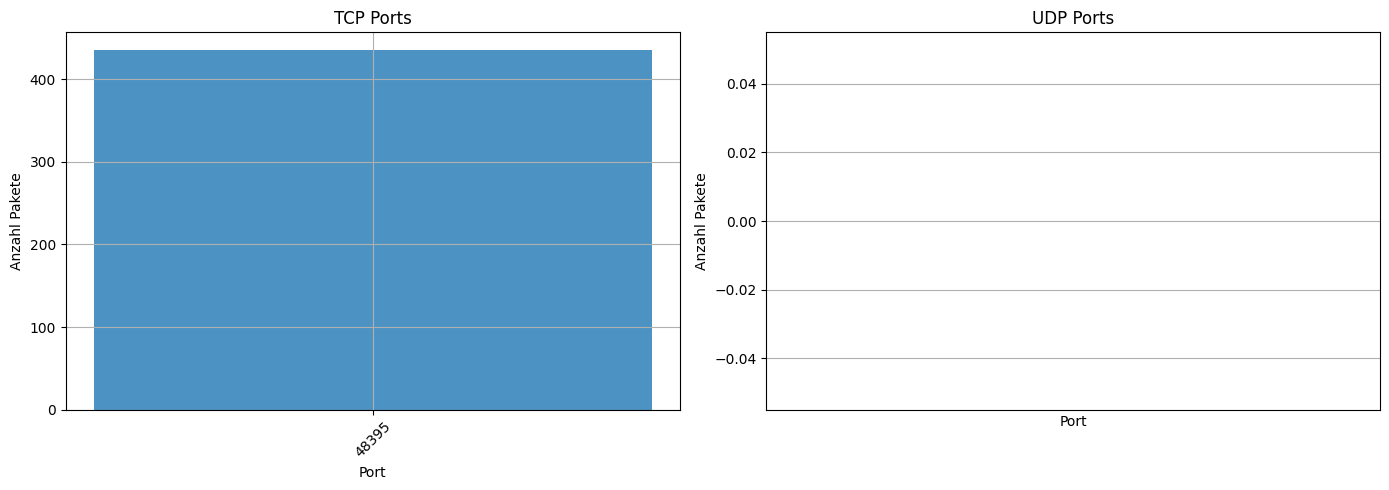

In [51]:
is_showed = False

# Extrahieren der TCP- und UDP-Ports
tcp_ports = [pkt[TCP].dport for pkt in filtered_packets if TCP in pkt]
udp_ports = [pkt[UDP].dport for pkt in filtered_packets if UDP in pkt]

print("Anzahl TCP Pakete:", len(tcp_ports))
print("Anzahl UDP Pakete:", len(udp_ports))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# TCP
tcp_port_counts = Counter(tcp_ports)
tcp_ports_sorted = sorted(tcp_port_counts.keys())
tcp_counts = [tcp_port_counts[port] for port in tcp_ports_sorted]
indices_tcp = range(len(tcp_ports_sorted))

axes[0].bar(indices_tcp, tcp_counts, width=0.8, alpha=0.8)
axes[0].set_title("TCP Ports")
axes[0].set_xlabel("Port")
axes[0].set_ylabel("Anzahl Pakete")
axes[0].grid(True)
axes[0].set_xticks(indices_tcp)
axes[0].set_xticklabels(tcp_ports_sorted, rotation=45)

# UDP
udp_port_counts = Counter(udp_ports)
udp_ports_sorted = sorted(udp_port_counts.keys())
udp_counts = [udp_port_counts[port] for port in udp_ports_sorted]
indices_udp = range(len(udp_ports_sorted))

axes[1].bar(indices_udp, udp_counts, width=0.8, alpha=0.8)
axes[1].set_title("UDP Ports")
axes[1].set_xlabel("Port")
axes[1].set_ylabel("Anzahl Pakete")
axes[1].grid(True)
axes[1].set_xticks(indices_udp)
axes[1].set_xticklabels(udp_ports_sorted, rotation=45)

plt.tight_layout()
plt.show()

if is_showed:
    print("TCP Ports und Anzahl der Pakete:")
    for port in tcp_ports_sorted:
        print(f"Port {port}: {tcp_port_counts[port]}")
    print("\nUDP Ports und Anzahl der Pakete:")
    for port in udp_ports_sorted:
        print(f"Port {port}: {udp_port_counts[port]}")


## Portanalyse (Payload-Grösse)

Analyse der an den Ports eingehenden Payload-Grössen, um typische Grössenverteilungen zu erkennen.

Anzahl TCP Pakete: 435
Anzahl UDP Pakete: 0


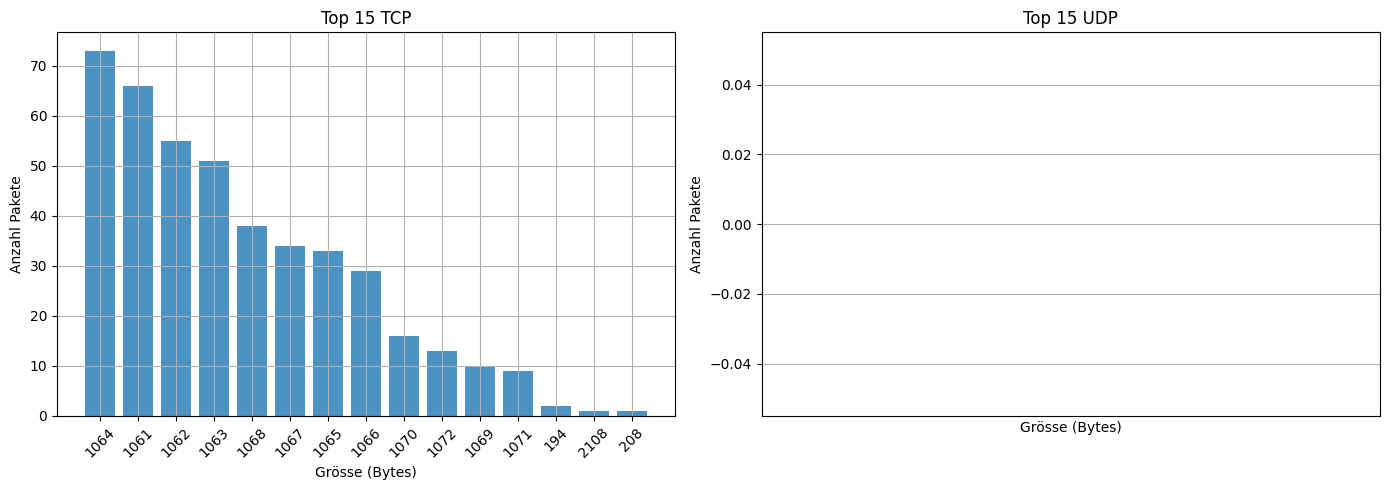

In [52]:
from collections import Counter
import matplotlib.pyplot as plt
from scapy.all import *

is_showed = False
top_output = 15

tcp_payload_sizes = [
    len(pkt[TCP].payload)
    for pkt in filtered_packets
    if TCP in pkt
]
udp_payload_sizes = [
    len(pkt[UDP].payload)
    for pkt in filtered_packets
    if UDP in pkt
]

print("Anzahl TCP Pakete:", len(tcp_payload_sizes))
print("Anzahl UDP Pakete:", len(udp_payload_sizes))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# TCP: Top Ausgeben
tcp_size_counts = Counter(tcp_payload_sizes)
top_tcp = tcp_size_counts.most_common(top_output)
tcp_sizes_top = [size for size, count in top_tcp]
tcp_counts_top = [count for size, count in top_tcp]
indices_tcp = range(len(top_tcp))

axes[0].bar(indices_tcp, tcp_counts_top, width=0.8, alpha=0.8)
axes[0].set_title(f"Top {top_output} TCP")
axes[0].set_xlabel("Grösse (Bytes)")
axes[0].set_ylabel("Anzahl Pakete")
axes[0].grid(True)
axes[0].set_xticks(indices_tcp)
axes[0].set_xticklabels(tcp_sizes_top, rotation=45)

# UDP: Top Ausgeben
udp_size_counts = Counter(udp_payload_sizes)
top_udp = udp_size_counts.most_common(top_output)
udp_sizes_top = [size for size, count in top_udp]
udp_counts_top = [count for size, count in top_udp]
indices_udp = range(len(top_udp))

axes[1].bar(indices_udp, udp_counts_top, width=0.8, alpha=0.8)
axes[1].set_title(f"Top {top_output} UDP")
axes[1].set_xlabel("Grösse (Bytes)")
axes[1].set_ylabel("Anzahl Pakete")
axes[1].grid(True)
axes[1].set_xticks(indices_udp)
axes[1].set_xticklabels(udp_sizes_top, rotation=45)

plt.tight_layout()
plt.show()

if is_showed:
    for size, count in sorted(top_tcp, key=lambda x: x[1], reverse=True):
        print(f"{size} Bytes: {count} Pakete")
    print(f"\nTop {top_output} UDP Paketgrössen (bytes) – sortiert nach Häufigkeit:")
    for size, count in sorted(top_udp, key=lambda x: x[1], reverse=True):
        print(f"{size} Bytes: {count} Pakete")

## 3. Paketgrössenanalyse

Es wird geprüft, wie häufig Pakete mit einer Grösse versendet wird.

show_details auf True setzen um die Details zu sehen


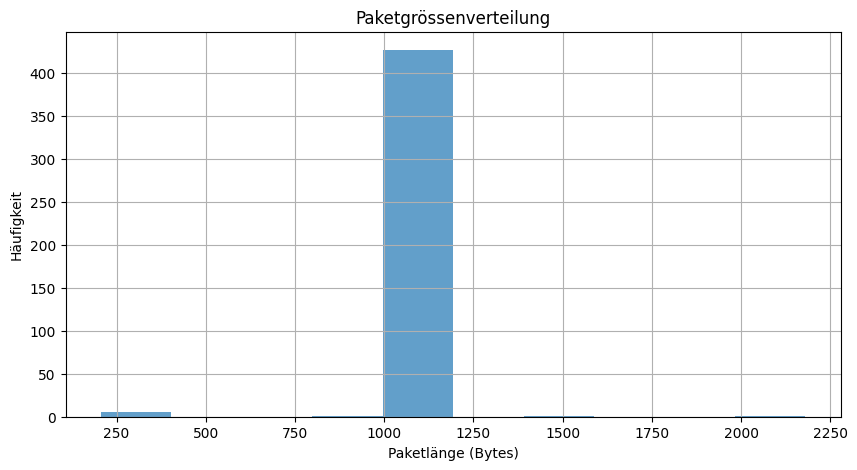

In [54]:
from collections import Counter
import matplotlib.pyplot as plt

show_details = False
packet_lengths = [len(pkt) for pkt in filtered_packets]

# Häufigkeit
length_counts = Counter(packet_lengths)
# Nach Häufigkeit sortieren
sorted_counts = sorted(length_counts.items(), key=lambda x: x[1], reverse=True)

if show_details:
    print("Paketlängen und Häufigkeiten:")
    for length, count in sorted_counts:
        print(f"{length} Bytes: {count}")
else:
    print("show_details auf True setzen um die Details zu sehen")

plt.figure(figsize=(10, 5))
plt.hist(packet_lengths, bins=10, alpha=0.7)
plt.xlabel('Paketlänge (Bytes)')
plt.ylabel('Häufigkeit')
plt.title('Paketgrössenverteilung')
plt.grid(True)
plt.show()


## Entropie-Analyse (Payload)

Eine hohe Entropie deutet darauf hin, dass eine starke Verschlüsselung verwendet wird.

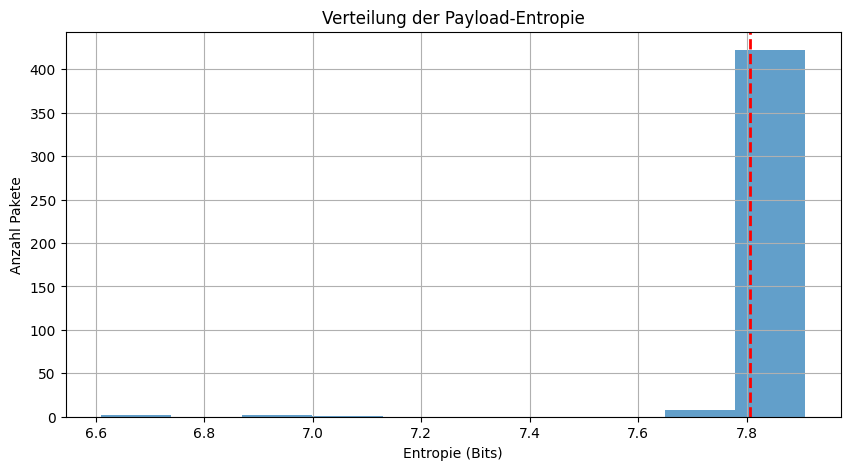


Durchschnittliche Entropie: 7.8057 Bits
Entropie (gerundet) | Anzahl Pakete
---------------------|----------------
Bin-Bereich (von - bis)       | Anzahl Pakete
--------------------------------|----------------
  6.6088 -   6.7388       |              2
  6.7388 -   6.8688       |              0
  6.8688 -   6.9988       |              2
  6.9988 -   7.1288       |              1
  7.1288 -   7.2588       |              0
  7.2588 -   7.3887       |              0
  7.3887 -   7.5187       |              0
  7.5187 -   7.6487       |              0
  7.6487 -   7.7787       |              8
  7.7787 -   7.9087       |            422


In [55]:
show_details = True


def calc_entropy(data):
    if not data:
        return 0
    counts = np.bincount(np.frombuffer(data, dtype=np.uint8), minlength=256)
    return entropy(counts, base=2)


entropies = [calc_entropy(bytes(pkt[Raw].load)) for pkt in filtered_packets if Raw in pkt]
mean_entropy = np.mean(entropies)
plt.figure(figsize=(10, 5))
plt.axvline(mean_entropy, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_entropy:.2f} Bits')
counts, bin_edges, _ = plt.hist(entropies, bins=10, alpha=0.7)
plt.xlabel('Entropie (Bits)')
plt.ylabel('Anzahl Pakete')
plt.title('Verteilung der Payload-Entropie')
plt.grid(True)
plt.show()

if show_details:
    print("\nDurchschnittliche Entropie: {:.4f} Bits".format(mean_entropy))
    print("Entropie (gerundet) | Anzahl Pakete")
    print("---------------------|----------------")
    print("Bin-Bereich (von - bis)       | Anzahl Pakete")
    print("--------------------------------|----------------")
    for i in range(len(counts)):
        start = bin_edges[i]
        end = bin_edges[i + 1]
        count = int(counts[i])
        print(f"{start:8.4f} - {end:8.4f}       | {count:>14}")


## Protokollverteilung (TCP vs. UDP)

Zeigt der Anteil der Pakete TCP bzw. UDP verwendet.

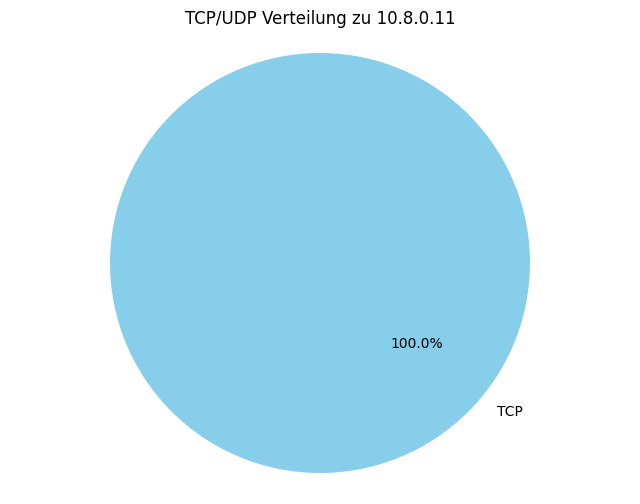

In [56]:
protocols = ["TCP" if TCP in pkt else "UDP" if UDP in pkt else "Andere" for pkt in filtered_packets]
protocol_counts = Counter(protocols)

plt.figure(figsize=(8, 6))
plt.pie(protocol_counts.values(), labels=protocol_counts.keys(), autopct='%1.1f%%', startangle=140,
        colors=['skyblue', 'salmon', 'grey'])
plt.axis('equal')
plt.title('TCP/UDP Verteilung zu 10.8.0.11')
plt.show()

# Start- und Endknoten finden

In [57]:
from scapy.all import IP, TCP, Raw
from collections import defaultdict
import re

show_details = True


def build_graph_from_pcap(packets):
    global graph, start_nodes_dict, hello_nodes, combined_events
    graph = defaultdict(list)
    pattern = r"GET http://.*HTTP"
    start_nodes_dict = defaultdict(list)
    hello_nodes = set()
    # (Zeilennummer, IP, Typ)
    combined_events = []

    for idx, pkt in enumerate(packets, start=1):
        if IP in pkt and TCP in pkt:
            src_ip = pkt[IP].src
            dst_ip = pkt[IP].dst
            src_port = pkt[TCP].sport
            dst_port = pkt[TCP].dport
            src_node = (src_ip, src_port)
            dst_node = (dst_ip, dst_port)
            pkt_time = pkt.time

            # Kante im Graphen speichern
            graph[src_node].append((dst_node, pkt_time))
            if pkt.haslayer(Raw):
                try:
                    payload = pkt[Raw].load.decode('utf-8', errors='ignore')
                except Exception:
                    payload = ""

                # Prüfe auf Request-Zeile
                if re.search(pattern, payload):
                    start_nodes_dict[dst_node].append(idx)
                    combined_events.append((idx, dst_ip, "GET"))
                # Suche nach Zeilen mit "Hello from"
                for line in payload.splitlines():
                    if "Hello from" in line:
                        hello_nodes.add(dst_ip)
                        combined_events.append((idx, src_ip, "HELLO"))

    return graph, dict(start_nodes_dict), hello_nodes, sorted(combined_events, key=lambda x: x[0])


def main():
    graph, start_nodes_dict, hello_nodes, combined_events = build_graph_from_pcap(packets)

    unique_get_nodes = sorted(set(start_nodes_dict.keys()))
    print("Eindeutige Startknoten:")
    for node in unique_get_nodes:
        ip, port = node
        print(f"{ip}:{port}")

    print("\nEindeutige Empfängerknoten:")
    for node in sorted(hello_nodes):
        ip = node
        print(f"{ip}")

    if show_details:
        print("\nAlle Einträge:")
        for line_num, ip, typ in combined_events:
            print(f"{line_num}: {ip} → {typ}")
    else:
        print("\nDetails können angezeigt werden indem die Variable show_details auf true gesetzt wird")


if __name__ == "__main__":
    main()

Eindeutige Startknoten:
10.8.0.2:4444

Eindeutige Empfängerknoten:
10.8.0.8
192.168.122.227

Alle Einträge:
732: 10.8.0.2 → GET
877: 10.43.72.4 → HELLO
1011: 10.8.0.2 → HELLO
1162: 10.8.0.2 → GET
1336: 10.43.72.4 → HELLO
1420: 10.8.0.2 → HELLO
1504: 10.8.0.2 → GET
1755: 10.43.72.4 → HELLO
1990: 10.8.0.2 → HELLO
2068: 10.8.0.2 → GET
2117: 10.43.72.4 → HELLO
2253: 10.8.0.2 → HELLO
2507: 10.8.0.2 → GET
2538: 10.43.72.4 → HELLO
2597: 10.8.0.2 → HELLO
2737: 10.8.0.2 → GET
2868: 10.43.72.4 → HELLO
2926: 10.8.0.2 → HELLO
3096: 10.8.0.2 → GET
3137: 10.43.72.4 → HELLO
3212: 10.8.0.2 → HELLO
3595: 10.8.0.2 → GET
3626: 10.43.72.4 → HELLO
3822: 10.8.0.2 → HELLO
4030: 10.8.0.2 → GET
4143: 10.43.72.4 → HELLO
4328: 10.8.0.2 → HELLO
4535: 10.8.0.2 → GET
4547: 10.43.72.4 → HELLO
4629: 10.8.0.2 → HELLO
5005: 10.8.0.2 → GET
5024: 10.43.72.4 → HELLO
5187: 10.8.0.2 → HELLO
5381: 10.8.0.2 → GET
5408: 10.43.72.4 → HELLO
5613: 10.8.0.2 → HELLO
5730: 10.8.0.2 → GET
5779: 10.43.72.4 → HELLO
5877: 10.8.0.2 → HEL

## Verbindungen die der Startknoten macht finden

In [58]:
from scapy.all import rdpcap, IP, TCP

show_details = True


def main():
    print("Auflistung alle Verbindungen vom Startknoten zu einem anderen Knoten:\n")

    # Filtere alle GET- und HELLO-Events in chronologischer Reihenfolge
    get_hello_events = [e for e in combined_events if e[2] in {"GET", "HELLO"}]

    for i, (get_line_num, get_ip, typ) in enumerate(get_hello_events):
        if typ != "GET":
            continue
        get_pkt = packets[get_line_num - 1]
        # Ermittle die Ziel-IP
        if IP in get_pkt and TCP in get_pkt:
            dst_ip = get_pkt[IP].dst
            dst_port = get_pkt[TCP].dport
        else:
            dst_ip = "?"
            dst_port = "?"
        # Ermittle den Startknoten
        matching_nodes = [node for node in start_nodes_dict if node[0] == get_ip]
        if not matching_nodes:
            continue
        get_node = matching_nodes[0]

        # Finde den nächsten Empfängerknoten, nachdem ein Startknoten ist.
        hello_line_num = None
        hello_ip = None
        for j in range(i + 1, len(get_hello_events)):
            if get_hello_events[j][2] == "HELLO":
                hello_line_num = get_hello_events[j][0]
                hello_ip = get_hello_events[j][1]
                break
        if hello_line_num is None:
            print(f"{get_line_num} GET:     {get_ip}:{get_node[1]} → {dst_ip}:{dst_port}")
            print("Kein folgendes HELLO gefunden.\n")
            continue

        end_index = min(hello_line_num, len(packets))

        # Suche alle Pakete zwischen dem Startknoten und dem Empfängerknoten. Nur die, welche den Startknoten als Sender haben.
        # Dabei werden Pakete ignoriert, deren Ziel-IP mit "192." beginnen.
        matching_connections = []
        seen_connections = set()  # Um Duplikate zu vermeiden
        for pkt_idx in range(get_line_num - 1, end_index):
            pkt = packets[pkt_idx]
            if IP in pkt and TCP in pkt:
                src = pkt[IP].src
                if src == get_node[0]:
                    conn_dst_ip = pkt[IP].dst
                    if conn_dst_ip.startswith("192."):
                        continue
                    conn_dst_port = pkt[TCP].dport
                    key = (conn_dst_ip, conn_dst_port)
                    if key not in seen_connections:
                        seen_connections.add(key)
                        matching_connections.append((pkt_idx + 1, conn_dst_ip, conn_dst_port))
        print(f"{str(get_line_num):<5} {'Sender:':<10}     {get_ip}:{get_node[1]}")
        print(f"{str(hello_line_num):<5} {'Empfänger:':<10} {hello_ip}")
        print(f"Anzahl Verbindungen (Unique):'{len(matching_connections)}")
        if show_details:
            print(f"Verbindung vom Startknoten zu anderen Knoten:")
            for line, conn_dst_ip, conn_dst_port in matching_connections:
                print(f"{line:<5}: {get_node[0]}:{get_node[1]} → {conn_dst_ip}:{conn_dst_port}")
        else:
            print("Details kann eingeblendet werden mit der Variabel show_details = True")
        print("-----------------------------")


if __name__ == "__main__":
    packets = rdpcap('traffic.pcap')
    main()

Auflistung alle Verbindungen vom Startknoten zu einem anderen Knoten:

732   Sender:        10.8.0.2:4444
877   Empfänger: 10.43.72.4
Anzahl Verbindungen (Unique):'0
Verbindung vom Startknoten zu anderen Knoten:
-----------------------------
1162  Sender:        10.8.0.2:4444
1336  Empfänger: 10.43.72.4
Anzahl Verbindungen (Unique):'1
Verbindung vom Startknoten zu anderen Knoten:
1307 : 10.8.0.2:4444 → 10.8.0.14:59939
-----------------------------
1504  Sender:        10.8.0.2:4444
1755  Empfänger: 10.43.72.4
Anzahl Verbindungen (Unique):'1
Verbindung vom Startknoten zu anderen Knoten:
1612 : 10.8.0.2:4444 → 10.8.0.11:48395
-----------------------------
2068  Sender:        10.8.0.2:4444
2117  Empfänger: 10.43.72.4
Anzahl Verbindungen (Unique):'1
Verbindung vom Startknoten zu anderen Knoten:
2072 : 10.8.0.2:4444 → 10.8.0.11:48395
-----------------------------
2507  Sender:        10.8.0.2:4444
2538  Empfänger: 10.43.72.4
Anzahl Verbindungen (Unique):'0
Verbindung vom Startknoten zu and